## *PriceSim: Navigating Markets with Probability Distributions*

<img src="price_oil.jpg" alt="oil price" width="550">

`packages`

In [1]:
# general
import pandas as pd          # pandas
import os, yaml, requests    # system
import numpy as np           # numpy
import math                  # math

# scipy
import scipy.stats as stats              # scipy
from scipy.stats import genhyperbolic    # genhyperbolic
from scipy.stats import dgamma           # dgamma
from scipy.stats import skewnorm         # skew normal

# stas models
import statsmodels.api as sm
from statsmodels.stats import descriptivestats

# fitter
from fitter import Fitter, get_common_distributions, get_distributions

# postgresql
import psycopg2
from sqlalchemy import create_engine

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('ggplot')

In [2]:
def read_yaml_file(yaml_file):
    """ load yaml cofigurations """

    config = None
    try:
        with open(yaml_file, 'r') as f:
            config = yaml.safe_load(f)
    except:
        raise FileNotFoundError('Couldnt load the file')

    return config


def get_db_conn_post(creds_file):
    """ Get an authenticated psycopg db connection, given a credentials file"""
    creds = read_yaml_file(creds_file)['db']

    connection = psycopg2.connect(
        user=creds['user'],
        password=creds['pass'],
        host=creds['host'],
        port=creds['port'],
        database=creds['db']
    )

    return connection

In [3]:
db_conn_post = get_db_conn_post("key_postgresql.yaml")

###  *`oil prices`*

_get the data from the database_

In [4]:
q = """
    select 
            *
    from 
            kaggle_data.crude_oil.wti_price;
"""

In [5]:
df_raw = pd.read_sql(sql = q, con = db_conn_post)
df_raw.head(3)

C:\Users\migue\AppData\Local\Temp/ipykernel_19268/3493397046.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_raw = pd.read_sql(sql = q, con = db_conn_post)


,date,price
0,2010-01-04,81.52
1,2010-01-05,81.74
2,2010-01-06,83.12


_review the data type_

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3586 entries, 0 to 3585
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3586 non-null   datetime64[ns]
 1   price   3455 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 56.2 KB


fill empty the data

In [7]:
df_raw['price'].fillna(method = 'ffill', inplace = True)

C:\Users\migue\AppData\Local\Temp/ipykernel_19268/3192405305.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_raw['price'].fillna(method = 'ffill', inplace = True)


In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3586 entries, 0 to 3585
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3586 non-null   datetime64[ns]
 1   price   3586 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 56.2 KB


In [9]:
df_raw.isnull().sum()

date     0
price    0
dtype: int64

The following chart illustrates the price trends from 2010. 

Over this period, we observe both price increases and decreases, with two notable turning points around 2014 and 2020. Particularly in 2020, we witnessed a substantial price drop, even reaching negative values.

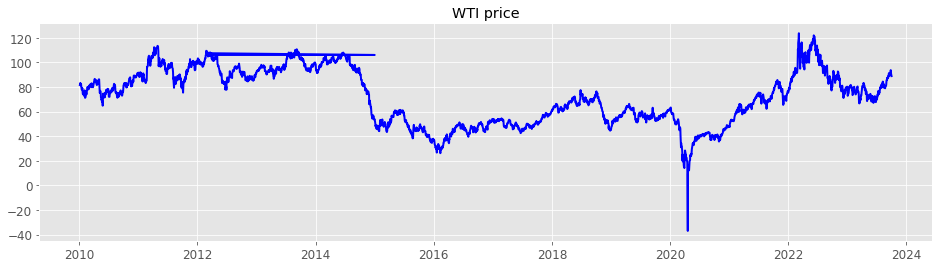

In [10]:
plt.figure(figsize=(16, 4))

plt.plot(df_raw['date'], 
         df_raw['price'], 
         color='blue', 
         linestyle='-', 
         linewidth=2)

plt.title('WTI price')
plt.show()

For this analysis, we have exclusively utilized price data spanning from 2019 to 2023

In [11]:
condition = df_raw['date'] >= '2019-01-01'
df = df_raw[condition]

Starting from 2019, we observe a rising trend in prices, with a notable exception in 2019 when prices temporarily dipped below zero due to the impact of the COVID-19 pandemic.

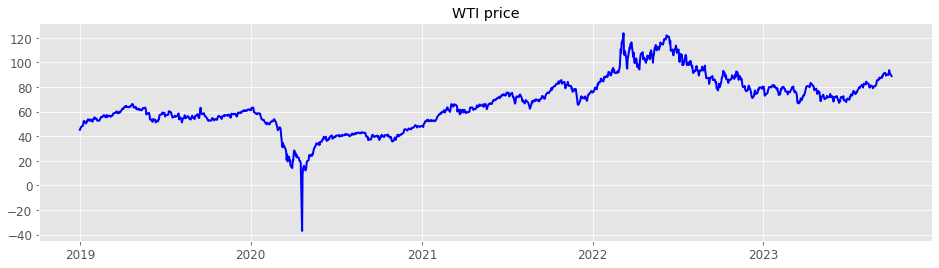

In [12]:
plt.figure(figsize=(16, 4))

plt.plot(df['date'], 
         df['price'], 
         color='blue', 
         linestyle='-', 
         linewidth=2)

plt.title('WTI price')
plt.show()

In [13]:
df['price'].describe()

count    1240.000000
mean       66.763476
std        21.163414
min       -36.980000
25%        53.547500
50%        65.640000
75%        80.160000
max       123.640000
Name: price, dtype: float64

The objective is to detect fluctuations over time, which will be used as a variable for categorizing prices based on their previous day's values

In [14]:
df['var'] = df['price'].diff()

C:\Users\migue\AppData\Local\Temp/ipykernel_19268/2233143251.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['var'] = df['price'].diff()


Many of the fluctuations are relatively minor, except for a significant exception when the price fell below zero due to the factors mentioned earlier

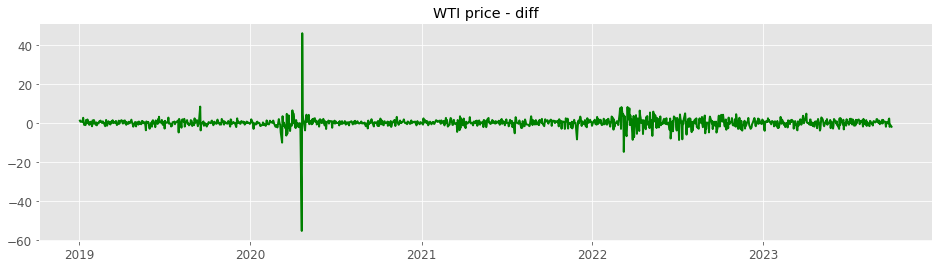

In [15]:
plt.figure(figsize=(16, 4))

plt.plot(df['date'], 
         df['var'], 
         color='green', 
         linestyle='-', 
         linewidth=2)

plt.title('WTI price - diff')
plt.show()

In [16]:
window_size = 1  # window size
df['smooth'] = df['var'].rolling(window = window_size).mean()

C:\Users\migue\AppData\Local\Temp/ipykernel_19268/806865353.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['smooth'] = df['var'].rolling(window = window_size).mean()


To create a smoother depiction of the fluctuations, we will apply a rolling average across all the variations.<br>
_Note: in the currect case our windows is 1, so we have the same in the previous difference and in the current smooth difference, the reason is because in another process use it a higher window return some errors._

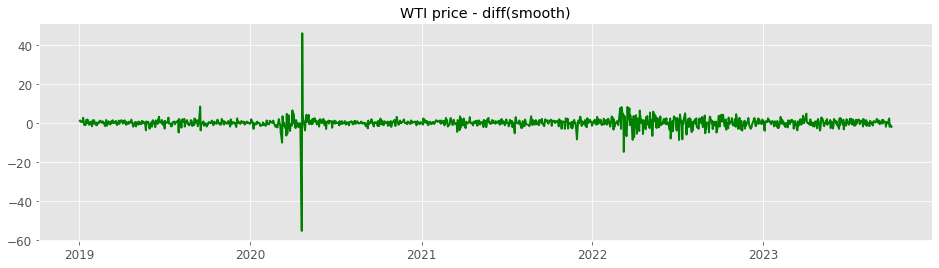

In [17]:
plt.figure(figsize=(16, 4))

plt.plot(df['date'], 
         df['smooth'], 
         color='green', 
         linestyle='-', 
         linewidth=2)

plt.title('WTI price - diff(smooth)')
plt.show()

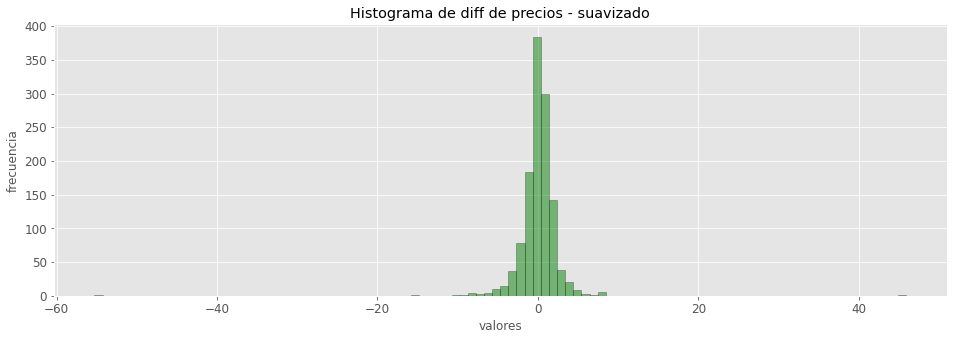

In [18]:
plt.figure(figsize=(16, 5))
plt.hist(df['smooth'],
         bins=100, 
         color='green', 
         alpha=0.5, 
         edgecolor='black')

plt.title('Histograma de diff de precios - suavizado')
plt.xlabel('valores')
plt.ylabel('frecuencia')
plt.grid(True)

plt.show()

Although we've smoothed the values (using the same window in this case), the standard deviation remains high.

In [19]:
df.describe()

,date,price,var,smooth
count,1240,1240.000000,1239.000000,1239.000000
mean,2021-05-16 21:36:00,66.763476,0.035238,0.035238
min,2019-01-01 00:00:00,-36.980000,-55.290000,-55.290000
25%,2020-03-09 18:00:00,53.547500,-0.740000,-0.740000
50%,2021-05-17 12:00:00,65.640000,0.080000,0.080000
75%,2022-07-25 06:00:00,80.160000,0.930000,0.930000
max,2023-10-02 00:00:00,123.640000,45.890000,45.890000
std,NaN,21.163414,2.770569,2.770569


***`temporal evaluation`***
<br><br>
Before proceeding with further analysis, I will delve deeper into the temporal behavior to determine whether we can identify any patterns over time.
<br>
Note: It's possible that there is some noise in the data due to outliers. Two significant events seem to correlate with these outliers: one corresponds to the onset of the COVID pandemic, and the other relates to the conflict in Europe.

In [20]:
df_backup = df.copy()   # before to continue I'll copy the raw data

In [21]:
start_date = '2019-01-01'
end_date = '2023-09-30'
idx_date = pd.date_range(start=start_date, end=end_date, freq='D')
df_dates = pd.DataFrame(idx_date, columns = ['date_continue'])

In [22]:
df = df.merge(df_dates, left_on = 'date', right_on = 'date_continue', how = 'right')
df.drop(columns = ['date'], inplace = True)
df.rename(columns = {'date_continue':'date'}, inplace = True)
df = df[['date', 'price', 'var', 'smooth']]
df.fillna(method = 'ffill', inplace = True)

C:\Users\migue\AppData\Local\Temp/ipykernel_19268/425146630.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method = 'ffill', inplace = True)


***`time series - price`***

In [23]:
df_temporal_raw = df.set_index('date')
y = df_temporal_raw['price'].resample('D').sum()

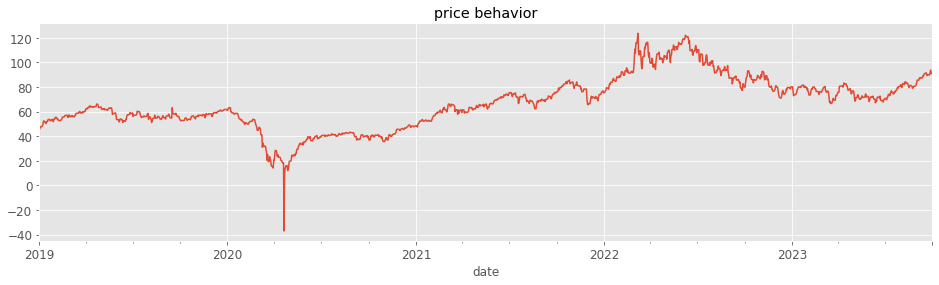

In [24]:
y.plot(figsize = (16,4))
plt.title('price behavior')
plt.show()

In [25]:
descriptivestats.describe(y)

c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\statsmodels\stats\descriptivestats.py:327: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dt) for dt in self._data.dtypes


,price
nobs,1734.000000
missing,0.000000
mean,66.786995
std_err,0.507878
upper_ci,67.782418
lower_ci,65.791572
std,21.148720
iqr,26.470000
iqr_normal,19.622240
mad,16.886446


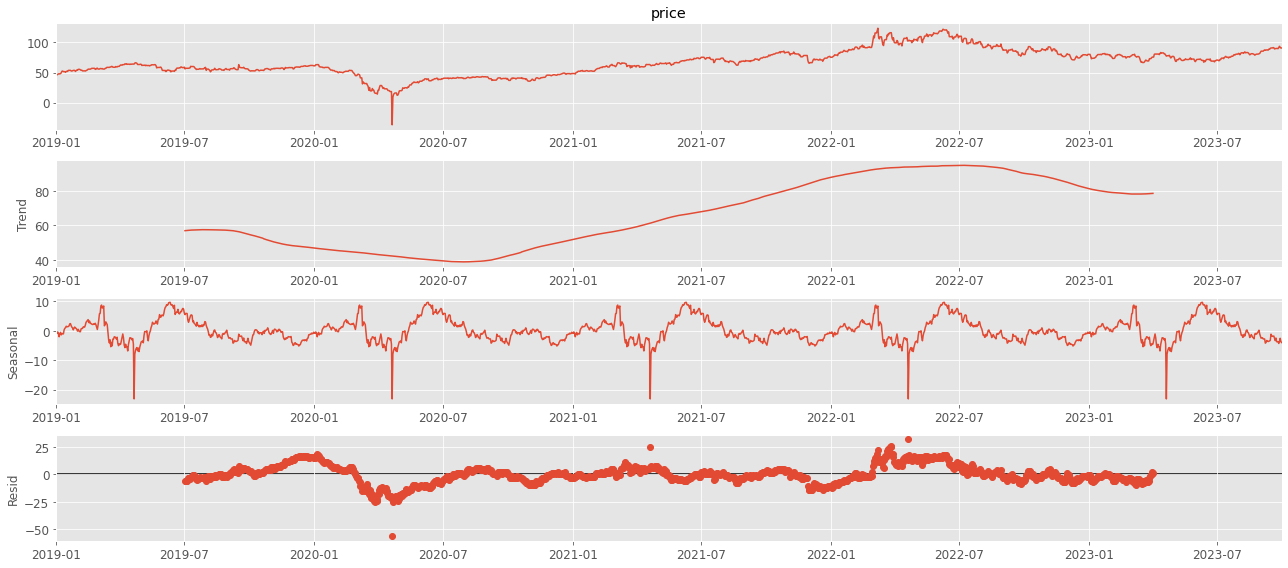

In [26]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, period = 365)
fig = decomposition.plot()
plt.show()

***`time series - price variation`***

In [27]:
df_temporal_raw = df.set_index('date')
y = df_temporal_raw['var'].fillna(0).resample('D').sum()

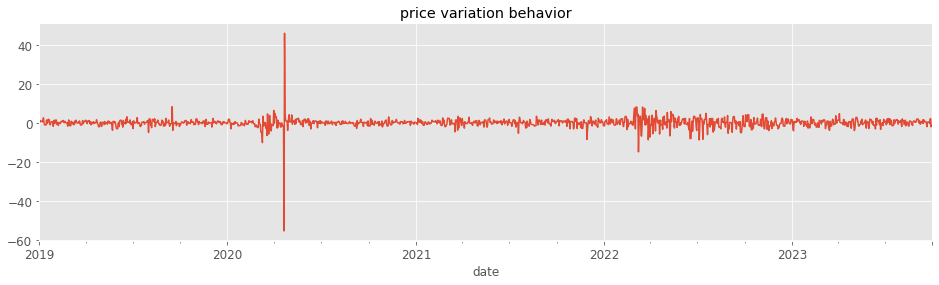

In [28]:
y.plot(figsize = (16,4))
plt.title('price variation behavior')
plt.show()

In [29]:
descriptivestats.describe(y)

c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\statsmodels\stats\descriptivestats.py:327: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dt) for dt in self._data.dtypes


,var
nobs,1.734000e+03
missing,0.000000e+00
mean,8.784314e-02
std_err,5.992534e-02
upper_ci,2.052947e-01
lower_ci,-2.960838e-02
std,2.495371e+00
iqr,1.670000e+00
iqr_normal,1.237973e+00
mad,1.276988e+00


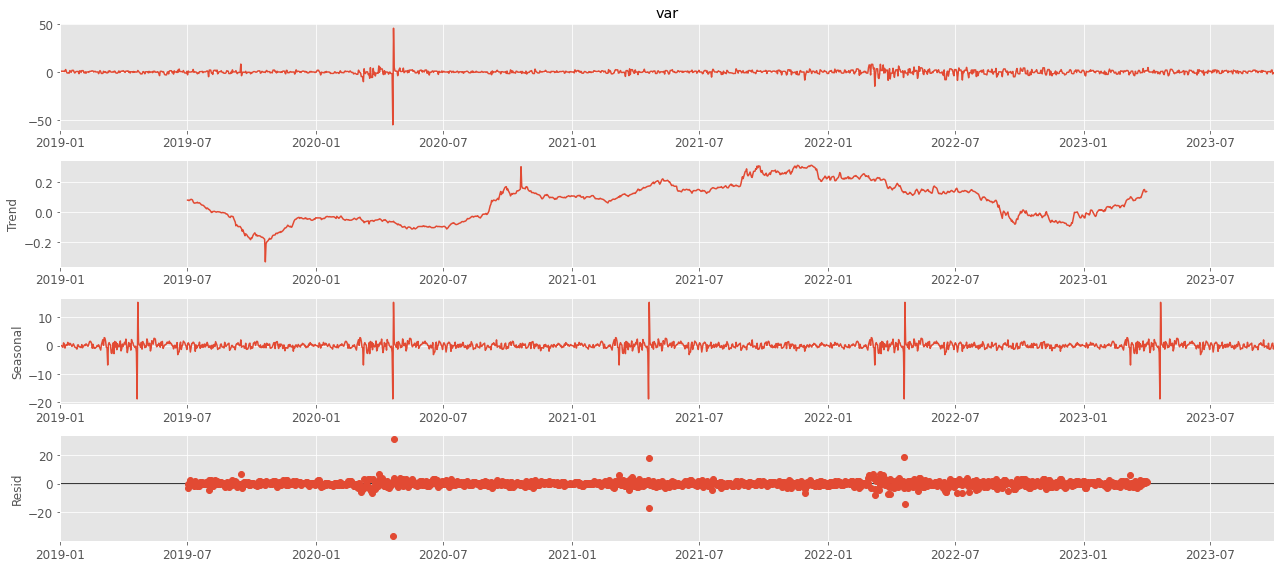

In [30]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, period = 365)
fig = decomposition.plot()
plt.show()

After a comprehensive analysis, we've detected distinct seasonality in both pricing and price variations. Nevertheless, it's important to acknowledge that this seasonality might be affected by the existence of outliers. To enhance the precision of our understanding, it is imperative that we take steps to address and minimize the influence of these outliers.

It's evident that these outliers have a substantial effect on our analysis. Our next approach will be to consider a logarithmic transformation. However, before proceeding with that, we'll first experiment with the Winsor technique.

The _Winsor_ procedure is a data preprocessing technique used to handle outliers or extreme values in a dataset. Instead of removing the outliers, as one would do in outlier removal, the Winsor procedure transforms them to reduce their influence on statistical analysis without losing critical information.

In [31]:
def winsor(df, col):
    
    col_series = pd.Series(df[col])                     # get the values
    pct1, pct99 = col_series.quantile([0.01, 0.99])     # get the quartile
    
    # winsor operation
    col_winsor = [
        pct1 if y < pct1
        else(
            pct99 if y > pct99 else y
        ) for y in col_series
    ]
    
    col_name = f"{col}_winsor"               # col name
    df[col_name] = col_winsor                # add the winsor data to the original dataframe
    return df

In [32]:
df.fillna(value = 0, inplace = True)       # fill the missing data of the original dataframe with 0

In [33]:
# winsor operation for the price and the variation
df = winsor(df, 'price')
df = winsor(df, 'var')

***`time series - price with winsor`***

In [34]:
df_temporal_raw = df.set_index('date')
y = df_temporal_raw['price_winsor'].resample('D').sum()

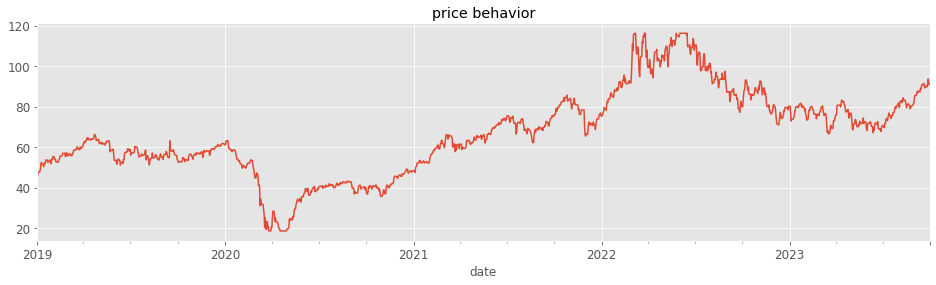

In [35]:
y.plot(figsize = (16,4))
plt.title('price behavior')
plt.show()

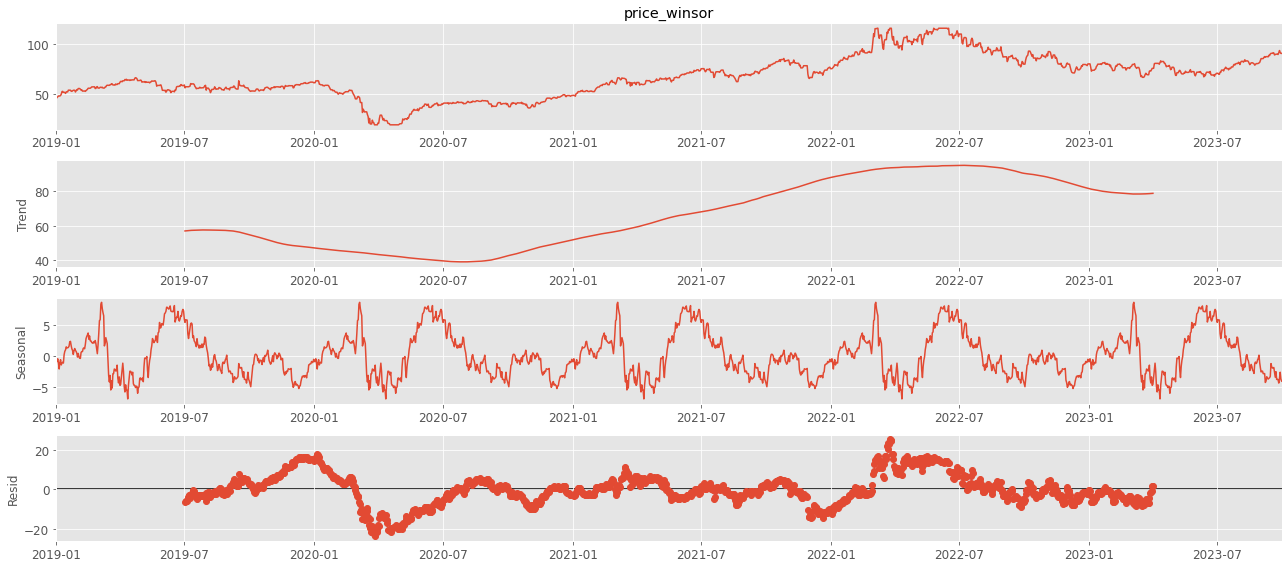

In [36]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, period = 365)
fig = decomposition.plot()
plt.show()

***`time series - price variation with winsor`***

In [37]:
df_temporal_raw = df.set_index('date')
y = df_temporal_raw['var_winsor'].resample('D').sum()

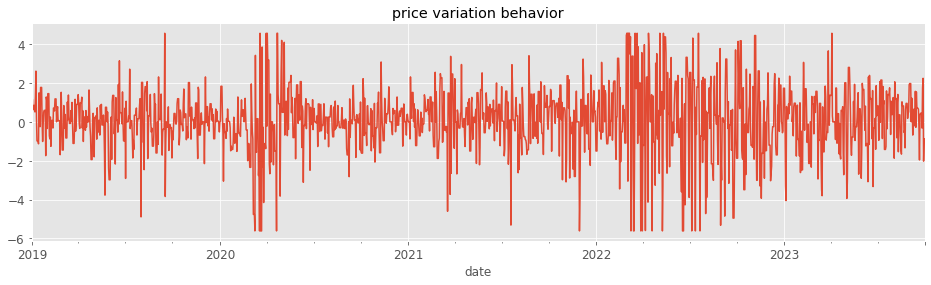

In [38]:
y.plot(figsize = (16,4))
plt.title('price variation behavior')
plt.show()

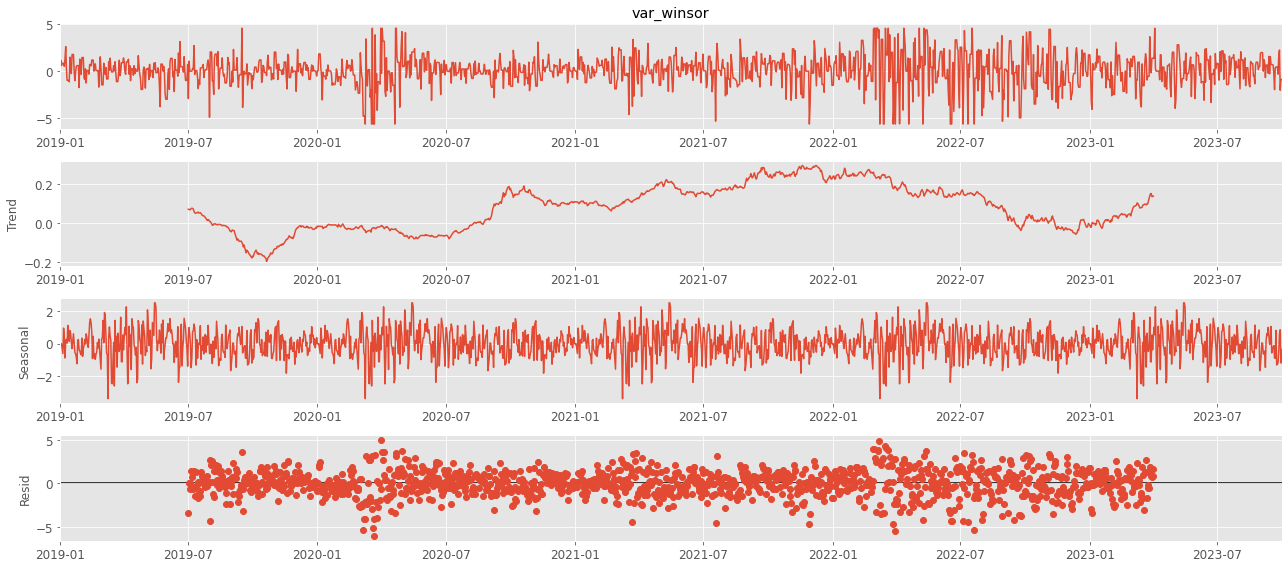

In [39]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, period = 365)
fig = decomposition.plot()
plt.show()

Examining the charts above, we've successfully reduced the impact of outliers. However, it's important to note that no distinct seasonal pattern can be assumed from the data. While we do observe a decrease in prices around May, it's primarily a result of the sharp drop in prices during the peak of the COVID-19 pandemic.

Our next objective is to continue the analysis of **prices** and their behavior. It is crucial to determine the type of distribution we are dealing with.

Our next test aims to assess how closely the distribution resembles a normal distribution

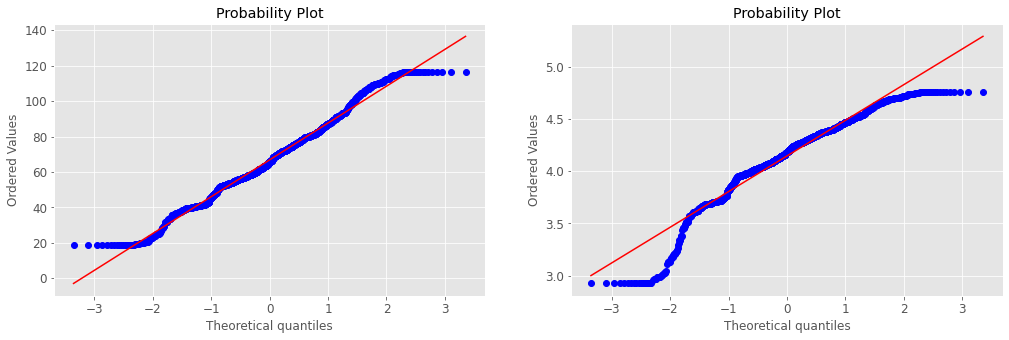

In [40]:
figure, ax = plt.subplots(1, 2, figsize=(17, 5))

stats.probplot(df['price_winsor'], dist='norm', plot=ax[0])
stats.probplot(np.log(df['price_winsor']), dist='norm', plot=ax[1])
plt.show()

c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


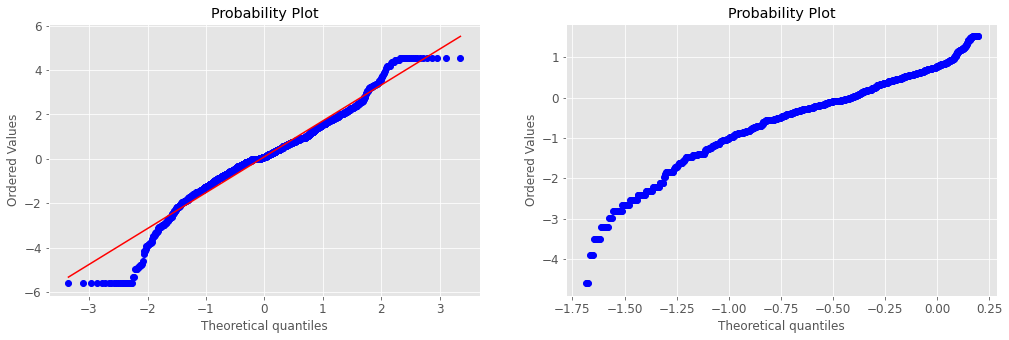

In [41]:
figure, ax = plt.subplots(1, 2, figsize=(17, 5))

stats.probplot(df['var_winsor'], dist='norm', plot=ax[0])
stats.probplot(np.log(df['var_winsor']), dist='norm', plot=ax[1])
plt.show()

***`distributions`***

Our conclusion is that the distribution doesn't conform to a normal distribution. To obtain the appropriate distribution, we employed the **`fitter`** package.<br>
This package performs iterative approximations of the distribution until it finds the closest match.
<br><br>
_Note: It's essential to emphasize that if the time exceeds 200, the process transitions to another distribution as the current one fails to converge._

In [42]:
col_smooth = df_backup['smooth'].values
nan_smooth = np.isnan(col_smooth)
col_smooth = col_smooth[~nan_smooth]

col_smooth_series = pd.Series(col_smooth)
pct1, pct99 = col_smooth_series.quantile([0.01, 0.99])

col_smooth_winsor = [
    pct1 if y < pct1
    else(
        pct99 if y > pct99 else y
    ) for y in col_smooth_series
]

Next, I will eliminate the null values, as mentioned earlier, they were filled with zeros. Our primary focus is to analyze the *price variations.*

c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_continuous_distns.py:3102: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  t1 = integrate.quad(llc, -np.inf, x)[0]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
genhyperbolic,0.158520,640.000881,665.611180,inf,0.147037,7.626617e-24
dgamma,0.166019,636.591731,651.957911,inf,0.043345,1.845299e-02
dweibull,0.166861,635.473692,650.839871,inf,0.043969,1.611462e-02
gennorm,0.170222,637.234617,652.600796,inf,0.033731,1.165883e-01
laplace,0.170226,635.164462,645.408582,inf,0.033551,1.201495e-01


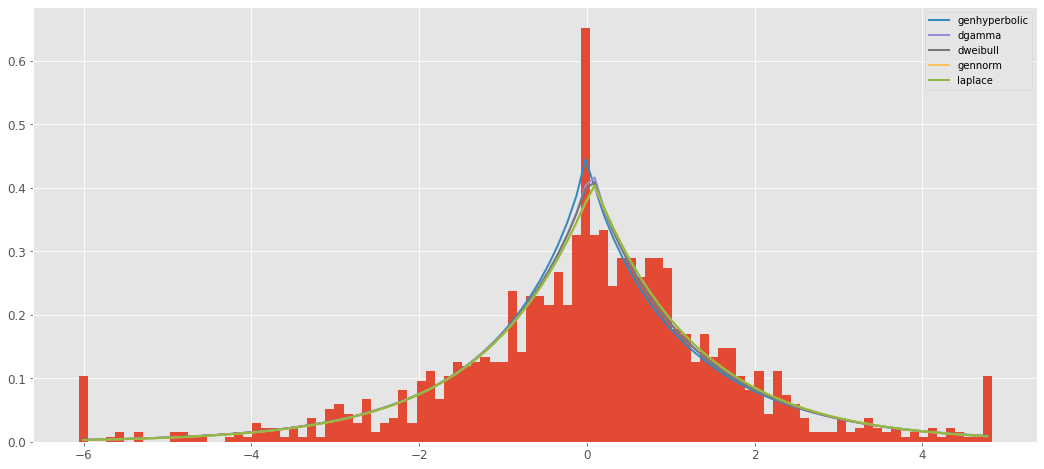

In [43]:
f = Fitter(col_smooth_winsor, distributions = ['genhyperbolic',
                                               'dgamma',
                                               'dweibull',
                                               'gennorm',
                                               'laplace'], timeout = 200)
f.fit()
f.summary()

*`Note: It's essential to mention that before narrowing down our distribution options, we tested numerous different distributions. The one that best fit our data was the Generalized Hyperbolic distribution, as illustrated in the chart.`*

<img src="fitter_var.png" alt="fitter price variation" width="550">

The table above indicates that the `Generalized Hyperbolic` distribution is the most suitable for our dataset, which has undergone the _Winsor_ technique.<br><br>

***`hyperbolic distribution`***<br>
The `generalised hyperbolic distribution` is a continuous probability distribution defined as the normal variance-mean mixture where the mixing distribution is the generalized inverse Gaussian distribution.<br><br>

The Generalized Hyperbolic distribution is also applied to modeling commodity prices and real assets, such as real estate. In our specific case, this relates to WTI prices.

It helps capture price patterns in these markets, including heavy tails and non-stationary fluctuations.<br>

The subsequent step involves calculating the *mean* and *standard deviation* for future analysis. This step is crucial because it aids in categorizing price variations as increases or decreases. Furthermore, it considers the *standard deviation* in relation to the *price* movements from the previous day.

get the parameters **$\alpha$, $\beta$, $\delta$, $\mu$, $\lambda$**

In [44]:
alpha_gh, beta_gh, delta_gh, mu_gh, lamb_gh = f.fitted_param['genhyperbolic']

For the `Generalized Hyperbolic distribution`, we will denote the parameters as follows:<br>
<br>
α as 'a'<br>
β as 'b'<br>
λ as 'p'<br>
<br>
Here are the interpretations of these parameters:<br>
'a' represents the shape parameter.<br>
'b' stands for the skewness parameter.<br>
'p' corresponds to the tail parameter.<br>

In [45]:
a = alpha_gh
b = beta_gh
p = lamb_gh

In [46]:
mean, var, skew, kurt = genhyperbolic.stats(p, a, b, moments='mvsk')
sd = math.sqrt(var)

Now, let's examine the mean and standard deviation.

In [47]:
print('mean: ', mean)
print('standard deviation: ', sd)

mean:  0.00012255868321741349
standard deviation:  1.2994261056998002


To determine the best-fitting distribution for our data, we conducted an analysis using the `fitter` package. It's important to clarify that the prior analysis focused on price variations, while the current analysis is centered on the actual price levels.

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
dgamma,0.002975,990.268352,1005.636952,inf,0.035111,0.091821
dweibull,0.002996,984.702413,1000.071013,inf,0.031790,0.159616
skewnorm,0.003329,978.852096,994.220696,inf,0.037247,0.062485
chi2,0.003330,978.243950,993.612550,inf,0.040466,0.033521
genhyperbolic,0.003331,982.617670,1008.232003,inf,0.037822,0.056118


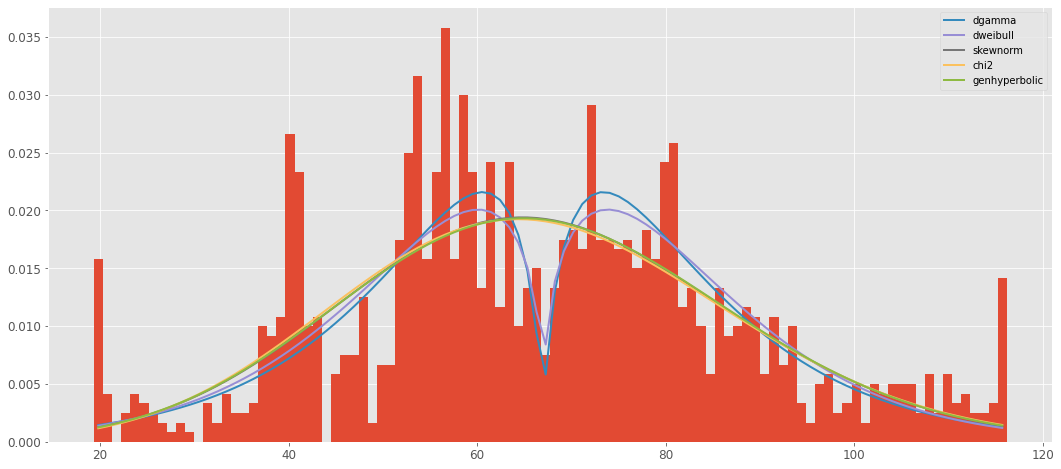

In [48]:
col_price = df_backup['price'].values
nan_price = np.isnan(col_price)
col_price = col_price[~nan_price]

col_price_series = pd.Series(col_price)
pct1, pct99 = col_price_series.quantile([0.01, 0.99])

col_price_winsor = [
    pct1 if y < pct1
    else(
        pct99 if y > pct99 else y
    ) for y in col_price_series
]


f = Fitter(col_price_winsor, distributions = ['dgamma',
                                              'dweibull',
                                              'skewnorm',
                                              'chi2',
                                              'genhyperbolic'], timeout = 200)
f.fit()
f.summary()

*`Note: It's essential to mention that before narrowing down our distribution options, we tested numerous different distributions. The one that best fit our data was the Double Gamma distribution, as illustrated in the chart.`*

<img src="fitter_price.png" alt="fitter oil price" width="550">

As observed earlier, the distribution that aligns most closely with the price distribution is a double gamma.<br><br>

***`double gamma`***<br>
The `double gamma distribution` is a continuous probability distribution that finds applications in statistics, particularly in data modeling and survival analysis.<br><br>

The `double gamma distribution` is frequently employed to model the time until an event occurs, such as the survival time of an electronic component. Additionally, it has been utilized to model the distribution of financial asset returns. It can also be applied in data analysis when the data distribution doesn't fit well with more common distributions, such as the normal distribution.<br><br>

In this particular example, we experimented with the distribution of variations to simulate diverse scenarios.

In [49]:
k_dgamma, theta_dgamma, delta_dgamma = f.fitted_param['dgamma']

In [50]:
dgamma.stats(k_dgamma, moments='mv')

(array(0.), array(4.23536805))

Now that we have identified the distributions, we can create *scenarios* and assess the associated risks. For this particular example, we will focus on price variations rather than the actual prices and aim to generate various *scenarios.*

***`scenarios`***<br>

In [51]:
a_gh = alpha_gh   # shape
b_gh = beta_gh    # skewness
p_gh = lamb_gh    # tail parameter
mean_gh, var_gh, skew_gh, kurt_gh = genhyperbolic.stats(p_gh, a_gh, b_gh, moments='mvsk')

In [52]:
shape_gh = alpha_gh
skewness_gh = beta_gh
kurtosis_gh = kurt_gh
scale_gh = delta_gh

In [53]:
random_data = genhyperbolic.rvs(p_gh, a_gh, b_gh, size = 350)

*the following illustrates how the probability density function compares with the random values*

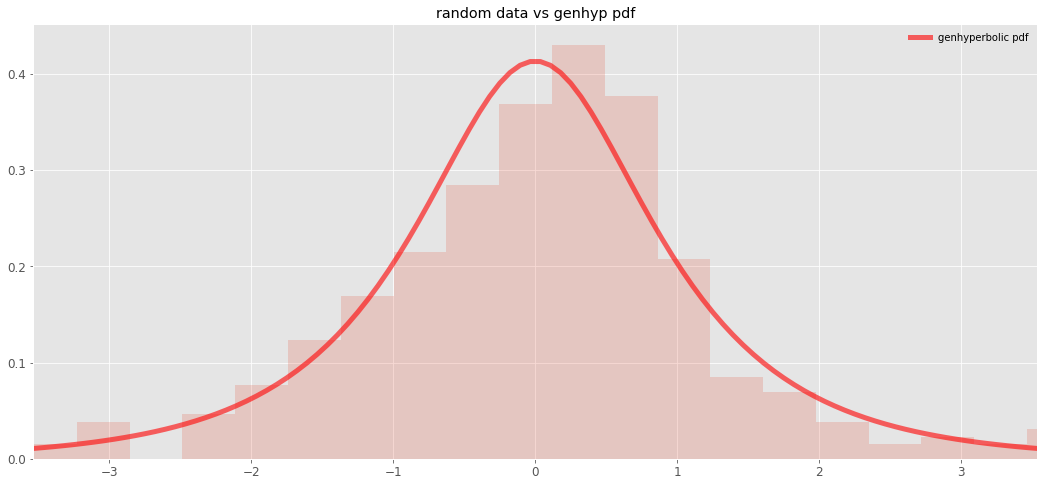

In [54]:
fig, ax = plt.subplots(1, 1)

x = np.linspace(genhyperbolic.ppf(0.01, p_gh, a_gh, b_gh),
                genhyperbolic.ppf(0.99, p_gh, a_gh, b_gh), 100)

ax.plot(x, genhyperbolic.pdf(x, p_gh, a_gh, b_gh),
       'r-', lw=5, alpha=0.6, label='genhyperbolic pdf')

ax.hist(random_data, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.set_xlim([x[0], x[-1]])
ax.legend(loc='best', frameon=False)
plt.title('random data vs genhyp pdf')
plt.show()

***`Monte Carlo`***<br><br>

`Monte Carlo simulation` stands as a robust statistical technique employed to model and assess the effects of diverse sources of uncertainty within a system. Its significance is particularly noteworthy for simulating scenarios across various domains.<br><br>

The following elucidates why Monte Carlo simulation plays a crucial role in simulating scenarios:<br>

- *Nature of Uncertainty:* real-world systems often feature inherent uncertainty and randomness. Monte Carlo simulation provides a means to integrate this uncertainty into models.

- *Parameter Variability:* uncertainty can stem from variations in parameters, market conditions, or other influencing factors. Monte Carlo methods effectively navigate and analyze the spectrum of potential outcomes.

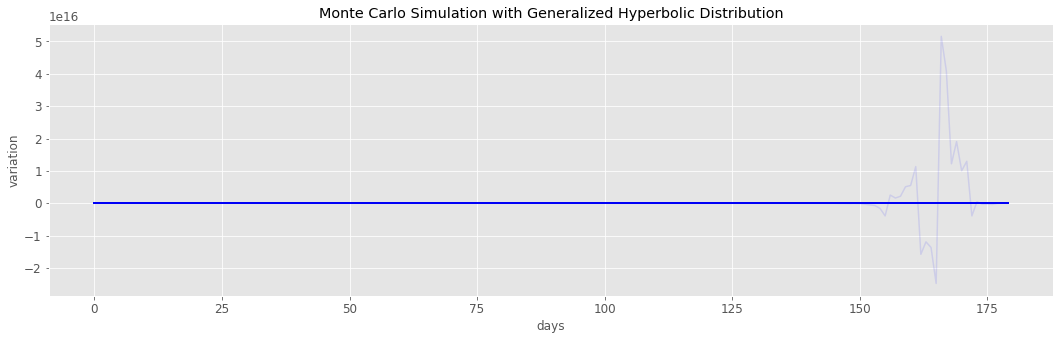

In [55]:
# Parameters
initial_price = -0.88          # Initial price
days = 180                     # Number of trading days in a year

# Monte Carlo Simulation
np.random.seed(42)         # Set seed for reproducibility
simulations = 1000

# Generate price paths
price_matrix = np.zeros((simulations, days))
price_matrix[:, 0] = initial_price

for i in range(1, days):
    daily_returns = genhyperbolic.rvs(p_gh, a_gh, b_gh, size = simulations)    
    price_matrix[:, i] = price_matrix[:, i - 1] * (1 + daily_returns)

# Plotting
plt.figure(figsize=(18, 5))
plt.plot(price_matrix.T, color='blue', alpha=0.1)
plt.title('Monte Carlo Simulation with Generalized Hyperbolic Distribution')
plt.xlabel('days')
plt.ylabel('variation')
plt.show()

The chart above represents a 180-day simulation of variations. I aim to replicate fluctuations to anticipate future trends and make informed decisions on pricing.

Observing the chart, it's evident that the variations are too high and may not accurately reflect the actual price behavior. This raises concerns about the possibility of making suboptimal decisions based on this simulation.

An important event in the simulation that can impact all scenarios is the decline in prices during the COVID-19 pandemic. As outlined in the notebook, we address this issue using some methods. The goal is to mitigate this effect, create an alternative representation of the true distribution, and generate new scenarios for simulating prices.
<br><br>
As depicted in the following boxplot, the majority of the data falls within the range of 55 USD to 80 USD. However, there are numerous outliers exceeding 100 USD and dropping below 30 USD. Additionally, a unique scenario arises where the price becomes negative, as previously explained.
<br><br>
Now, addressing the issue of outliers, we'll apply the capping technique to trim the data for atypical values, specifically those below 20 USD and above 100 USD—values attributed to exceptional circumstances.

In this instance, we'll compute the Q1 and Q3 values to establish the limits for high and low values, using them as thresholds. This step precedes the subsequent matching of the probability distribution.

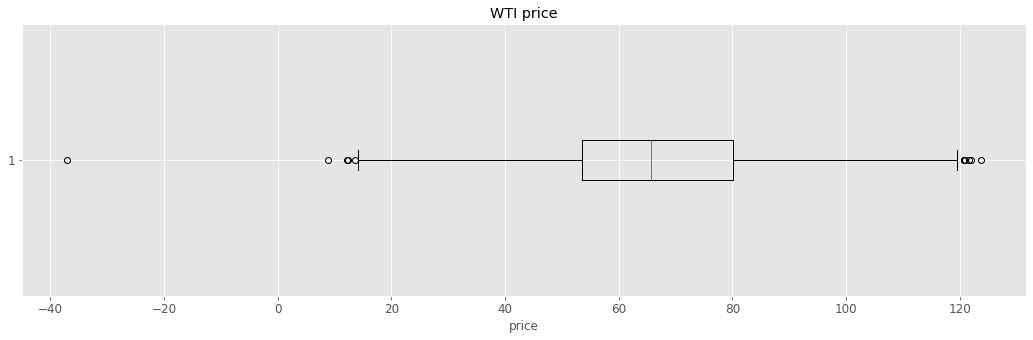

In [56]:
plt.figure(figsize = (18,5))
plt.boxplot(df['price'], vert=False, patch_artist=False)
plt.xlabel('price')
plt.title('WTI price')
plt.show()

***`Capping`***

In [57]:
q1_price = df['price'].quantile(0.25)
q3_price = df['price'].quantile(0.75)
print(f'q1:{q1_price} - q3:{q3_price}')

q1:53.6 - q3:80.07


In [58]:
cond_list = [df['price'] > q3_price, df['price'] < q1_price]    
choice_list = [q3_price, q1_price]
df['price_capped'] = np.select(cond_list, choice_list, df['price'])

Upon comparing the capped prices with the original prices, we draw the following conclusion: the initially set limits aren't optimal for our approach. In this case, we've adjusted the limits to **20 USD** and **120 USD**. This adjustment is crucial as continuing with the current capped prices might introduce bias into our conclusions.

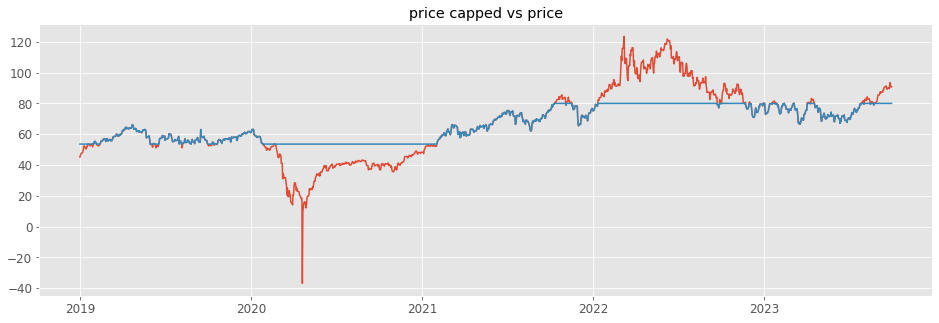

In [59]:
plt.figure(figsize = (16,5))
plt.plot(df['date'], df['price'])
plt.plot(df['date'], df['price_capped'])
plt.title('price capped vs price')
plt.show()

In [60]:
up_limit = 120
low_limit = 20
cond_list = [df['price'] > up_limit, df['price'] < low_limit]    
choice_list = [up_limit, low_limit]
df['price_capped'] = np.select(cond_list, choice_list, df['price'])

Now the price data appears more refined, allowing us to proceed. There are a few price points where data is capped, particularly in the lower range of prices.

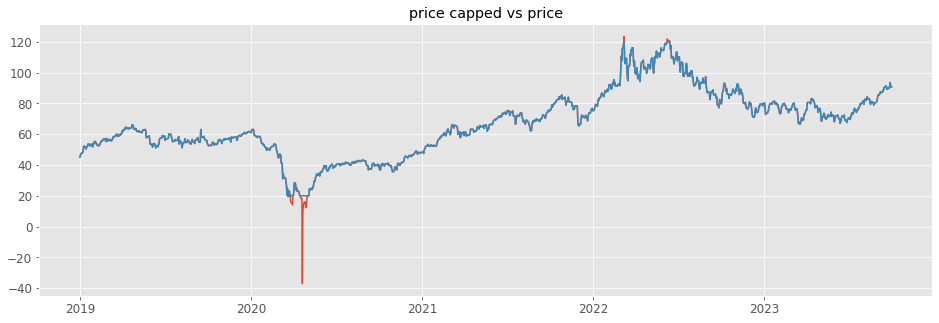

In [61]:
plt.figure(figsize = (16,5))
plt.plot(df['date'], df['price'])
plt.plot(df['date'], df['price_capped'])
plt.title('price capped vs price')
plt.show()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
dgamma,0.002857,1002.253580,1018.628139,inf,0.037347,0.015457
dweibull,0.002903,997.367252,1013.741811,inf,0.032501,0.050173
skewnorm,0.003262,990.281381,1006.655939,inf,0.040028,0.007512
exponweib,0.003263,992.151160,1013.983904,inf,0.040462,0.006651
nct,0.003264,993.280512,1015.113257,inf,0.038076,0.012766


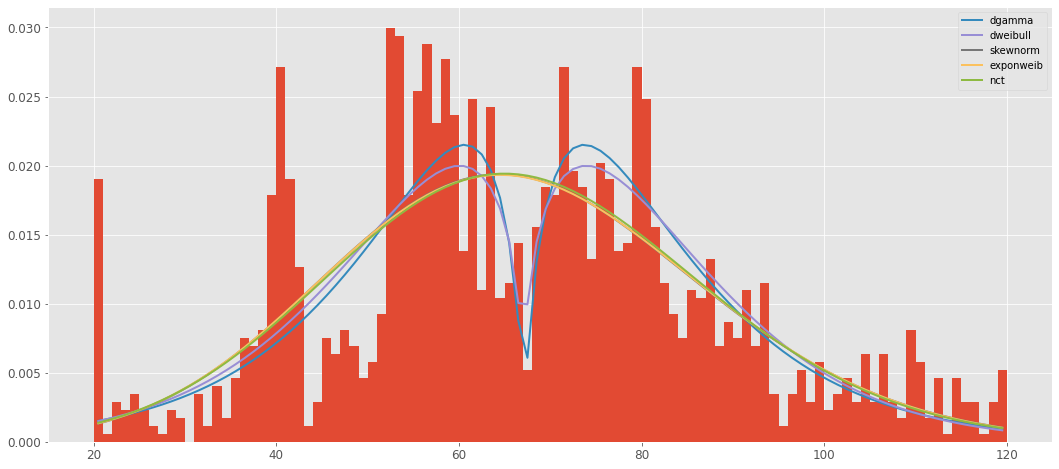

In [62]:
f = Fitter(df['price_capped'], distributions = ['dgamma',
                                                'dweibull',
                                                'skewnorm',
                                                'exponweib',
                                                'nct'], timeout = 200)
f.fit()
f.summary()

*`Note: It's essential to mention that before narrowing down our distribution options, we tested numerous different distributions.`*

<img src="fitter_price_adjust.png" alt="fitter oil price" width="550">

Although the optimal distribution is the double gamma, we have decided to choose the skewness normal distribution based on the following considerations.
- aic: The _Akaike Information Criterion (AIC)_ is a measure that assesses the relative quality of a statistical model. _AIC_ takes into consideration both the model's fitting ability and the amount of information it employs (number of parameters). The goal is to select the model with the lowest _AIC_ value, indicating a good balance between fit and complexity.
- bic: The _Bayesian Information Criterion (BIC)_ is a statistical measure employed for model selection. Similar to the Akaike Information Criterion (AIC), the _BIC_ assesses the relative quality of models fitted to the data. However, it imposes a stronger penalty for model complexity.

In [63]:
a_sn, mean_sn, stdev_sn = f.fitted_param['skewnorm']

In [64]:
print(f'mean: {mean_sn}')
print(f'std dev: {stdev_sn}')
print(f'skewness: {a_sn}')

mean: 50.132782133661486
std dev: 26.76574634075089
skewness: 1.2581533538398522


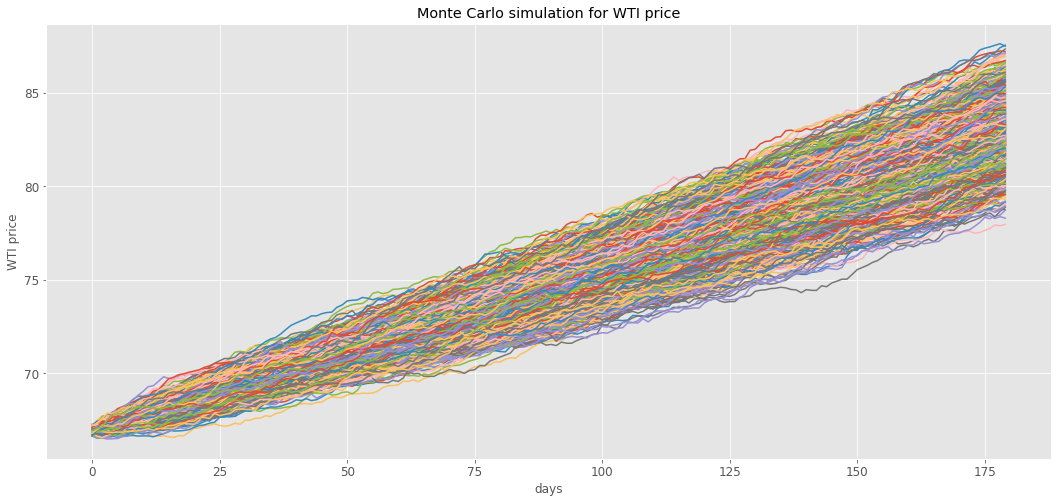

In [65]:
historical_prices = df['price_capped']
historical_returns = np.log(historical_prices / historical_prices.shift(1)).dropna()

np.random.seed(42)
mu = np.mean(historical_returns)
sigma = np.std(historical_returns)
skewness = a_sn 
days = 180                
simulations = 1000              

daily_returns = skewnorm.rvs(a=skewness, loc=mu/days, scale=sigma/np.sqrt(days), size=(simulations, days))
price_matrix = np.cumprod(1 + daily_returns, axis=1)

price_base = df['price_capped'].mean()
price_simulated = price_base * price_matrix.T

plt.plot(price_simulated)
plt.title('Monte Carlo simulation for WTI price')
plt.xlabel('days')
plt.ylabel('WTI price')
plt.show()

In [69]:
print('mean price: ', np.mean(price_simulated))
print('std price: ', np.std(price_simulated))

mean price:  74.64128982511409
std price:  4.749593556162553
